The goal of this project is to build a small language model which generates very short stories.

I will build a decoder-only Transformer model from scratch -- and train it on data from the Tiny Stories dataset, which is a collection of very short stories used for training small language models.

Transformer-based models like GPT-3 have demonstrated impressive capabilities in generating coherent and contextually relevant text, making them useful for applications like creative writing, conversational agents, and content generation.

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
import os
import math
import random

import pandas as pd
import numpy as np
import sentencepiece as spm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

from nltk.translate.bleu_score import corpus_bleu
from tqdm import tqdm


In [ ]:
# Paths
os.chdir('/content/gdrive/My Drive/Colab Notebooks/Transformers and Tiny Stories/')

tiny_stories_train = 'TinyStoriesV2-GPT4-train.txt'
tiny_stories_val = "TinyStoriesV2-GPT4-valid.txt"
tiny_stories_100 = "tiny_stories_100.txt"
tiny_stories_1000 = "tiny_stories_1000.txt"
tiny_stories_10000 = "tiny_stories_10000.txt"

train_set_path = "train_set.txt"
val_set_path = "val_set.txt"

spm_model = 'spm.model'

Pre-processing

Truncate the stories because longer ones tend to be nonsensicle.

In [ ]:
# Preprocess the tiny stories dataset

story_limit = 100

# Read the input text file
with open('test_stories.txt', 'r') as file:
    lines = file.readlines()

# Initialize variables to store reformatted stories
reformatted_stories = []

# Iterate through the lines
story = ''
num_stories = 0
for line in lines:
    if line.strip() == '<|endoftext|>':
        # End of story symbol found, add the current story to the list and reset story variable
        reformatted_stories.append(story)
        story = ''
        num_stories += 1
        if num_stories == story_limit:
            break
    else:
        # Concatenate lines of the current story
        story += line.strip() + ' '

# Truncate stories to 1500 characters
reformatted_stories = [story[:1500] for story in reformatted_stories]

# Write the reformatted stories to a new text file
with open('reformatted_tiny_stories_train.txt', 'w') as file:
    for story in reformatted_stories:
        file.write(story + '\n')


In [ ]:
# Open the larger text file for reading
with open('reformatted_tiny_stories_train.txt', 'r') as larger_file:
    # Read the first 10000 rows
    tiny_10 = [next(larger_file) for _ in range(10)]

# Shuffle the lines randomly
random.shuffle(tiny_10)

# Calculate the number of lines for the training set and validation set
total_lines = len(tiny_10)
train_size = int(0.8 * total_lines)
val_size = total_lines - train_size

print("Train set:", train_size)
print("Val set:", val_size)

# Split the lines into training set and validation set
train_set = tiny_10[:train_size]
val_set = tiny_10[train_size:]

print("Actual Train set:", len(train_set))
print("Actual Val set:", len(val_set))

# Write the training set to a file
with open(train_set_path, 'w') as train_file:
    for line in train_set:
        train_file.write(line)

## Write the training set to a file
with open(val_set_path, 'w') as val_file:
    for line in val_set:
        val_file.write(line)


Train set: 8
Val set: 2
Actual Train set: 8
Actual Val set: 2


In [ ]:
vocab_size = 4500
model_prefix = 'spm'

# Train SentencePiece model
spm.SentencePieceTrainer.train(f'--pad_id=0 --bos_id=1 --eos_id=2 --unk_id=3 --input={tiny_stories_10000} --model_prefix={model_prefix} --vocab_size={vocab_size}')


In [ ]:
# Load pre-trained tokenizer
sp = spm.SentencePieceProcessor()
sp.load(spm_model)

# Get the actual vocabulary size
vocab_size = sp.get_piece_size()
print(sp.id_to_piece(2))

# Print the actual vocabulary size
print("Actual vocabulary size:", vocab_size)


</s>
Actual vocabulary size: 4500


In [ ]:
class Tokenizer:
    def __init__(self):

        # Initialize an empty set to store unique words
        unique_words = set()

        # Read the text file line by line and tokenize each line into words
        with open('reformatted_tiny_stories_train.txt', 'r', encoding='utf-8') as file:
            for line in file:
                words = line.split()
                unique_words.update(words)

        vocab = ['<pad>', '<s>', '</s>'] + sorted(set(unique_words))

        self.stoi = {c: i for i, c in enumerate(vocab)}
        self.itos = {i: c for i, c in enumerate(vocab)}
        self.vocab_size = len(vocab)

    def encode(self, story):
        return [self.stoi[w] for w in story.split()]

    def decode(self, tokens):
        return ' '.join([self.itos[t] for t in tokens])


tokenizer = Tokenizer()
vocab_size = tokenizer.vocab_size
print("Vocabulary size:", vocab_size)
print(tokenizer.itos)

# Example
story_encoded = tokenizer.encode('cat sat')
story_decoded = tokenizer.decode([599, 1870])
print(story_encoded)
print(story_decoded)


Vocabulary size: 2485
{0: '<pad>', 1: '<s>', 2: '</s>', 3: '"', 4: '"Actually,', 5: '"Ahoy,', 6: '"Are', 7: '"Bad', 8: '"Be', 9: '"Bob', 10: '"But', 11: '"Can', 12: '"Daddy,', 13: '"Do', 14: '"Don\'t', 15: '"Freeze!"', 16: '"Frog', 17: '"Go', 18: '"Good', 19: '"Goodbye,', 20: '"He', 21: '"Hello!', 22: '"Hello,', 23: '"Help', 24: '"Help,', 25: '"Hey,', 26: '"Hi', 27: '"Hi!', 28: '"Hi,', 29: '"How', 30: '"I', 31: '"I\'m', 32: '"It', 33: '"It\'s', 34: '"Jen', 35: '"John!', 36: '"Let\'s', 37: '"Lily,', 38: '"Look', 39: '"Look,', 40: '"Mama,', 41: '"Max', 42: '"Maybe', 43: '"Mom', 44: '"Mom,', 45: '"My', 46: '"No!', 47: '"No,', 48: '"OK,', 49: '"Of', 50: '"Oh', 51: '"Oh,', 52: '"Okay,', 53: '"Okay,"', 54: '"Ollie,', 55: '"One,', 56: '"Please', 57: '"Rex', 58: '"Sam,', 59: '"She', 60: '"Sorry".', 61: '"Spirits', 62: '"Stop', 63: '"Sue,', 64: '"Sure,', 65: '"Teddy,', 66: '"Thank', 67: '"That', 68: '"That\'s', 69: '"The', 70: '"This', 71: '"Tim,', 72: '"Tom,', 73: '"Tweet,', 74: '"We', 75: '"W

In [ ]:
tiny_X = torch.tensor([[1, 3, 4, 5, 6, 3, 7, 0, 0, 0, 0, 0]])
tiny_y = torch.tensor([[3, 4, 5, 6, 3, 7, 2, 0, 0, 0, 0, 0]])

# Generate some very simple data to test
story_input = '<s> the cat sat on the mat <pad> <pad> <pad>'
print(story_input.split())
story_target = 'the cat sat on the mat </s> <pad> <pad> <pad>'
print(story_target.split())

tiny_X = torch.tensor(tokenizer.encode(story_input))
tiny_y = torch.tensor(tokenizer.encode(story_target))
print(tiny_X)
print(tiny_y)


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, stories):
        self.x = [s.strip() for s in stories.split('\n') if s.strip()]
        self.y = self.x[:]
        self.tokenizer = Tokenizer()
        #self.sp = spm.SentencePieceProcessor()

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        #print(self.x[idx])
        x_encoded = self.tokenizer.encode(self.x[idx])
        y_encoded = self.tokenizer.encode(self.y[idx])
        #print(x_encoded)
        #x_check = self.tokenizer.decode(x_encoded)
        #y_check = self.tokenizer.decode(y_encoded)
        #print(x_check)

        #x_encoded = self.sp.encode(self.x[idx])
        #y_encoded = self.sp.encode(self.y[idx])

        # Add <s> and </s> tokens
        x_tensor = torch.tensor([1] + x_encoded)
        y_tensor = torch.tensor(y_encoded + [2])

        return [x_tensor, y_tensor]


In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        # Ensure that the model dimension (d_model) is divisible by the number of heads
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        # Initialize dimensions
        self.d_model = d_model # Model's dimension
        self.num_heads = num_heads # Number of attention heads
        self.d_k = d_model // num_heads # Dimension of each head's key, query, and value

        # Linear layers for transforming inputs
        self.W_q = nn.Linear(d_model, d_model) # Query transformation
        self.W_k = nn.Linear(d_model, d_model) # Key transformation
        self.W_v = nn.Linear(d_model, d_model) # Value transformation
        self.W_o = nn.Linear(d_model, d_model) # Output transformation

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        # Calculate attention scores
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)

        # Apply mask if provided (useful for preventing attention to certain parts like padding)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)

        # Softmax is applied to obtain attention probabilities
        attn_probs = torch.softmax(attn_scores, dim=-1)

        # Multiply by values to obtain the final output
        output = torch.matmul(attn_probs, V)
        return output

    def split_heads(self, x):
        # Reshape the input to have num_heads for multi-head attention
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)

    def combine_heads(self, x):
        # Combine the multiple heads back to original shape
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)

    def forward(self, Q, K, V, mask=None):
        # Apply linear transformations and split heads
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))
        # Perform scaled dot-product attention
        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
        # Combine heads and apply output transformation
        output = self.W_o(self.combine_heads(attn_output))
        return output


In [ ]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        #self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, x_mask):
        # Next line is the issue
        attn_output = self.self_attn(x, x, x, x_mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

In [ ]:
class MySimpleTransformer(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout):
        super(MySimpleTransformer, self).__init__()
        self.decoder_embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.fc = nn.Linear(d_model, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def generate_mask(self, x):
        # Create a boolean tensor where True indicates non-zero elements and False indicates zero elements
        x_mask = (x != 0).unsqueeze(1).unsqueeze(3)

        seq_length = x.size(1)
        nopeek_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool()
        x_mask = x_mask & nopeek_mask
        return x_mask

    def forward(self, x, mask=False):
        # Generate mask only during training
        if mask:
            x_mask = self.generate_mask(x)
        else:
            x_mask = None

        x_embedded = self.dropout(self.positional_encoding(self.decoder_embedding(x)))

        for dec_layer in self.decoder_layers:
            dec_output = dec_layer(x_embedded, x_mask)

        # Run the output through a fully connected layer
        output = self.fc(dec_output)

        # Apply softmax activation function along the last dimension
        output = F.softmax(output, dim=-1)

        return output

In [ ]:
def padding_fn(batch):

    # Unpack the batch into x and y tensors
    x_batch, y_batch = zip(*batch)

    # Pad sequences and labels to the same length
    padded_x = pad_sequence(x_batch, batch_first=True, padding_value=0)
    padded_y = pad_sequence(y_batch, batch_first=True, padding_value=0)

    return padded_x, padded_y


In [ ]:
max_seq_length = 211
d_model = 56
num_heads = 1
num_layers = 1
d_ff = 1
dropout = 0.1
learning_rate = 0.01
num_epochs = 10
batch_size = 8

'''
with open(train_set_path, 'r') as file:
    # Read the entire contents of the file into a single string
    train_stories = file.read()

with open(val_set_path, 'r') as file:
    # Read the entire contents of the file into a single string
    val_stories = file.read()
'''



with open(train_set_path, 'r') as file:
    # Read the entire contents of the file into a single string
    train_stories = val_stories = file.read()



# Create the datasets and the data loaders
train_dataset = CustomDataset(train_stories)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=padding_fn)

val_dataset = CustomDataset(val_stories)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, collate_fn=padding_fn)

# Create the model, loss function and optimizer
transformer = MySimpleTransformer(vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout)
criterion = nn.CrossEntropyLoss(reduction='sum', ignore_index=0)  # ignore_index=0 will ensure that padding is ignored
optimizer = Adam(transformer.parameters(), lr=learning_rate)

# Set the transformer model to training mode, enabling behaviors like dropout
transformer.train()


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(transformer):,} trainable parameters')

The model has 293,966 trainable parameters


In [ ]:
sos = torch.tensor([1])
eos = torch.tensor([2])

# Initialize early stopping parameters
patience = 5
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_state = None

epoch_train_loss = []
epoch_val_loss = []
for epoch in tqdm(range(num_epochs)):

    print("START_EPOCH")

    # Training phase
    transformer.train()

    batch_train_loss = []
    for batch in train_dataloader:

        # Unpack the batch into x and y tensors
        x_batch, y_batch = batch

        optimizer.zero_grad()
        output = transformer(x_batch, mask=True)

        #print(output.shape)

        output_tensor = output.view(-1, output.size(2))
        y_tensor = y_batch.view(-1)

        loss = criterion(output_tensor, y_tensor)
        batch_train_loss.append(loss.item())
        loss.backward()
        optimizer.step()

    # Compute training loss for the epoch
    train_loss = np.mean(batch_train_loss)
    epoch_train_loss.append(train_loss)

    # Validation phase
    transformer.eval()  # Set model to evaluation mode

    batch_val_loss = []
    with torch.no_grad():  # Disable gradient calculation during validation
        for batch in val_dataloader:

            # Unpack the batch into x and y tensors
            x_batch, y_batch = batch

            output = transformer(x_batch, mask=True)

            output_tensor = output.view(-1, output.size(2))
            y_tensor = y_batch.view(-1)

            loss = criterion(output_tensor, y_tensor).item()
            batch_val_loss.append(loss)

    # Compute val loss for the epoch
    val_loss = np.mean(batch_val_loss)
    epoch_val_loss.append(val_loss)

    # Check if validation loss improved
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = transformer.state_dict()
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    # Print epoch results
    print(f'Epoch {epoch+1}: Training Loss: {epoch_train_loss[-1]}, Validation Loss: {epoch_val_loss[-1]}')

    # Check for early stopping
    if epochs_without_improvement >= patience:
        print(f'Early stopping after {epoch+1} epochs.')
        break


# Use the best model state
if best_model_state is not None:
    transformer.load_state_dict(best_model_state)
    torch.save(transformer.state_dict(), 'best_model.pth')


  0%|          | 0/10 [00:00<?, ?it/s]

START_EPOCH


 20%|██        | 2/10 [00:00<00:02,  3.90it/s]

Epoch 1: Training Loss: 8560.75, Validation Loss: 8560.369140625
START_EPOCH
Epoch 2: Training Loss: 8560.3896484375, Validation Loss: 8559.6171875
START_EPOCH


 40%|████      | 4/10 [00:00<00:01,  5.24it/s]

Epoch 3: Training Loss: 8559.7041015625, Validation Loss: 8558.2216796875
START_EPOCH
Epoch 4: Training Loss: 8558.4306640625, Validation Loss: 8556.2451171875
START_EPOCH


 60%|██████    | 6/10 [00:01<00:00,  6.08it/s]

Epoch 5: Training Loss: 8556.544921875, Validation Loss: 8553.703125
START_EPOCH
Epoch 6: Training Loss: 8554.1865234375, Validation Loss: 8550.1708984375
START_EPOCH


 80%|████████  | 8/10 [00:01<00:00,  6.52it/s]

Epoch 7: Training Loss: 8550.9228515625, Validation Loss: 8545.2568359375
START_EPOCH
Epoch 8: Training Loss: 8546.462890625, Validation Loss: 8537.5595703125
START_EPOCH


100%|██████████| 10/10 [00:01<00:00,  5.91it/s]

Epoch 9: Training Loss: 8539.619140625, Validation Loss: 8525.1669921875
START_EPOCH
Epoch 10: Training Loss: 8528.0302734375, Validation Loss: 8508.24609375


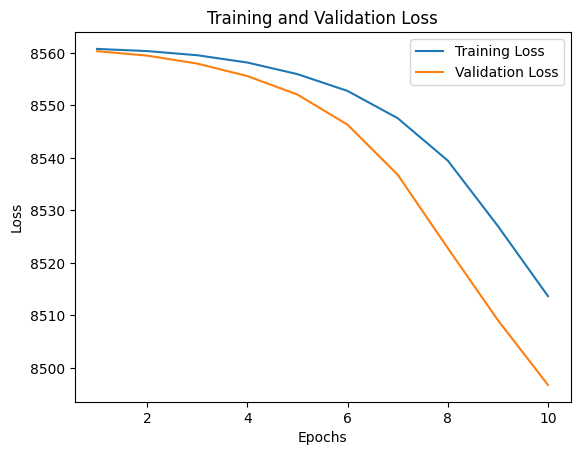

In [ ]:
# Plot loss over epochs
epochs = np.array(range(1, epoch+2))

plt.plot(epochs, epoch_train_loss, label='Training Loss')
plt.plot(epochs, epoch_val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
decoder_input = 'Sara'  # leave as '' or add a prompt (start of story)
if decoder_input == '':
    decoder_input = sos.unsqueeze(dim=0)
else:
    decoder_input = torch.cat([sos, torch.tensor(tokenizer.encode(decoder_input))]).unsqueeze(dim=0)

while True:
    p_all = transformer(torch.tensor(decoder_input))
    p_last = p_all[:, -1, :]
    p_last = torch.nn.functional.softmax(p_last, dim=1)
    p_last = torch.argmax(p_last, dim=1).unsqueeze(dim=0)

    decoder_output = torch.cat((decoder_input, p_last), dim=1)

    if (decoder_output[0, -1] == 2) or (decoder_output.size(1) == max_seq_length):
        break
    else:
        decoder_input = decoder_output.clone()


decoder_output = decoder_output.squeeze().tolist()
print("Generate:", tokenizer.decode(decoder_output))

<ipython-input-15-fe51d3ae6b14>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  p_all = transformer(torch.tensor(decoder_input))


Generate: <s> Sara the and the and the and the and the and the and the and the and the and the and the and the and the and the and the and the and the and the and the and the and the and the and the and the and the and the and the and the and the and the and the and the and the and the and the and the and the and the and the and the and the and the and the and the and the and the and the and the and the and the and the and the and the and the and the and the and the and and and and and the and the and the and and and the and the and the and the and the and the and the and the and and the and the and the and and and and the and the and and and and and and and and and and the and the and the and the and the and the and the and the and the and the and the and the and the and the dog the and the and the dog the and the and the and the dog the and


Greedy search

In [ ]:
def greedy_search(model, img, tokenizer, max_length, index_to_word):
    """
    Greedy Search decoding strategy to generate a caption describing an image

    Args:
        model: image captioning model
        img: image feature vector
        tokenizer: tokenizer used for text processing
        max_length: maximum length of caption
        index_to_word: mapping of word indices to words in vocabulary

    Returns:
        caption: most likely caption found by Greedy Search
    """

    # Initialize input sequence
    caption = 'startseq'

    for _ in range(max_length):
        # Convert input sequence to integers using the tokenizer
        sequence = tokenizer.texts_to_sequences([caption])[0]
        # Pad input sequence
        padded_sequence = pad_sequences([sequence], maxlen=max_length)
        # Predict the next word probabilities
        yhat = model.predict([img, padded_sequence], verbose=0)
        # Get the index of the word with the highest probability
        yhat = np.argmax(yhat)
        # Map the index to the word
        word = index_to_word[yhat]
        # Stop if cannot map the word or if it is an end token
        if word is None:
            break
        elif word == 'endseq':
            caption += f' {word}'
            break
        # Add the predicted word to the input sequence
        else:
            caption += f' {word}'

    return caption


def read_image(path, img_size=299):
    # Load and resize an image in square format
    # and convert it to an array representation
    img = load_img(path, target_size=(img_size, img_size))
    img = img_to_array(img)/255.

    return img


def review_captions(decode_strategy, id, index_to_word, encoded_test_images,
                    test_captions, model, tokenizer, max_length):

    # Plot the Flickr8k image and captions, and the model generated caption
    img = encoded_test_images[id].reshape((1, 2048))  # batch size = 1
    y_pred = decode_strategy(model, img, tokenizer, max_length, index_to_word)
    y_pred = y_pred.replace('startseq ', '')  # Remove start tag
    y_pred = y_pred.replace(' endseq', '')  # Remove end tag

    print('\n\n--- Flickr8k Dataset Captions ---------------------------------')
    for caption in test_captions[id]:
        caption = caption.replace('startseq ', '')  # Remove start tag
        caption = caption.replace(' endseq', '')  # Remove end tag
        print(caption)

    print('\n---Caption Predicted by Model----------------------------------')
    print(y_pred)

    plt.figure(figsize=(3,3))
    image = read_image(image_path + id)
    plt.imshow(image)
    plt.axis('off')
    plt.show()


def sample_predictions(k, decode_strategy, index_to_word, encoded_test_images,
                       test_captions, model, tokenizer, max_length):

    random_test_images = random.choices(list(encoded_test_images.keys()), k=k)
    for id in tqdm(random_test_images):
        review_captions(decode_strategy, id, index_to_word, encoded_test_images,
                        test_captions, model, tokenizer, max_length)


# Invert the word_index to create a dictionary of index to word
index_to_word = {index: word for word, index in word_index.items()}

# Demo Greedy Search with random sample of test images and associated captions
sample_size = 5
sample_predictions(sample_size, greedy_search, index_to_word, encoded_test_images,
                   test_captions, model, tokenizer, max_length)


In [ ]:
def beam_search(model, img, tokenizer, max_length, index_to_word, beam_width=3):
    """
    Beam Search decoding strategy to generate a caption describing an image

    Args:
        model: image captioning model
        img: image feature vector
        tokenizer: tokenizer used for text processing
        max_length: maximum length of caption
        index_to_word: mapping of word indices to words in vocabulary
        beam_width: width of the beam
            (most probable candidate sequences retained at each step)

    Returns:
        caption: most likely caption found by Beam Search
    """

    # Initialize input sequence
    start_word = [tokenizer.word_index['startseq']]

    # Start with single beam
    beams = [(0.0, start_word)]  # (log-likelihood, sequence)

    while len(beams[0][1]) < max_length:
        new_beams = []
        for log_prob, sequence in beams:
            padded_sequence = pad_sequences([sequence], maxlen=max_length)
            yhat = model.predict([img, padded_sequence], verbose=0)
            top_words = np.argsort(yhat[0])[-beam_width:]

            # Expand each current beam
            for word_index in top_words:
                new_sequence = sequence + [word_index]
                new_log_prob = log_prob + yhat[0][word_index]

                new_beams.append((new_log_prob, new_sequence))

        # Keep only the top beams
        beams = sorted(new_beams, reverse=True)[:beam_width]

        # Check if any beam has reached the end sequence
        best_sequence = beams[0][1]
        if best_sequence[-1] == tokenizer.word_index['endseq']:
            break

    # Construct the final caption from the best beam
    caption = [index_to_word[idx] for idx in best_sequence]
    caption = ' '.join(caption)

    return caption


# Invert the word_index to create a dictionary of index to word
index_to_word = {index: word for word, index in word_index.items()}

# Demo Beam Search with random sample of test images and associated captions
sample_size = 5
sample_predictions(sample_size, beam_search, index_to_word, encoded_test_images,
                   test_captions, model, tokenizer, max_length)


BLEU SCORES

Generate some random stories (use a seed?)
and then evaluate them.

In [ ]:
# Using test dataset, create lists of actual captions and predicted captions
test_actual, test_predicted = [], []

for id in tqdm(test_captions):
    # get actual caption
    captions = test_captions[id]
    # predict the caption for image
    img = encoded_test_images[id].reshape((1,2048))

    # Uncomment preferred decoding strategy
    y_pred = beam_search(model, img, tokenizer, max_length, index_to_word, beam_width=7)
    #y_pred = greedy_search(model, img, tokenizer, max_length, index_to_word)

    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    test_actual.append(actual_captions)
    test_predicted.append(y_pred)


# Calculate BLEU scores
bleu_scores = {}
bleu_scores['BLEU-1'] = corpus_bleu(test_actual, test_predicted,
                                    weights=(1.0, 0, 0, 0))
bleu_scores['BLEU-2'] = corpus_bleu(test_actual, test_predicted,
                                    weights=(0.5, 0.5, 0, 0))
bleu_scores['BLEU-3'] = corpus_bleu(test_actual, test_predicted,
                                    weights=(0.33, 0.33, 0.33, 0))
bleu_scores['BLEU-4'] = corpus_bleu(test_actual, test_predicted,
                                    weights=(0.25, 0.25, 0.25, 0.25))

# Save BLEU scores to pickle
model_variation = 'baseline_beam_width7_e8'
pickle.dump(bleu_scores,
            open(f'{working_directory}bleuscores_{model_variation}.pkl', 'wb'))

# Print BLEU scores
print(f"Model Variation: {model_variation}")
print(f"BLEU-1 Score: {bleu_scores['BLEU-1']}")
print(f"BLEU-2 Score: {bleu_scores['BLEU-2']}")
print(f"BLEU-3 Score: {bleu_scores['BLEU-3']}")
print(f"BLEU-4 Score: {bleu_scores['BLEU-4']}")




NameError: name 'test_captions' is not defined

In [ ]:
# Load BLEU scores from pickle
model_variation = 'baseline_beam_width3_e5'
with open(f'{working_directory}bleuscores_{model_variation}.pkl', 'rb') as f:
    bleu_scores = pickle.load(f)

# Print BLEU scores
print(f"Model Variation: {model_variation}")
print(f"BLEU-1 Score: {bleu_scores['BLEU-1']}")
print(f"BLEU-2 Score: {bleu_scores['BLEU-2']}")
print(f"BLEU-3 Score: {bleu_scores['BLEU-3']}")
print(f"BLEU-4 Score: {bleu_scores['BLEU-4']}")


#Bes' code:

In [ ]:
import random
import torch
import math


torch.manual_seed(42)


class Tokenizer:
  def __init__(self):
    f = open('/root/tiny-transformer/names.txt', 'r')
    names = f.read().splitlines()
    vocab = ['<pad>', '<eos>', '<sos>'] + sorted(set(''.join(names)))
    self.stoi = {c:i for i, c in enumerate(vocab)}
    self.itos = {i:c for i, c in enumerate(vocab)}
    self.vocab_size = len(vocab)
    f.close()

  def encode(self, name):
    return [self.stoi[c] for c in name]

  def decode(self, tokens):
    return ''.join([self.itos[t] for t in tokens])


tokenizer = Tokenizer()
# print(tokenizer.vocab_size)  # 29
foo = tokenizer.encode('john') # [2, 12, 17, 10, 16, 1]
bar = tokenizer.decode(foo)    # john


class Dataset(torch.utils.data.Dataset):
  def __init__(self):
    f = open('/root/tiny-transformer/names.txt', 'r')
    self.names = f.read().split('\n')
    self.tokenizer = Tokenizer()
    f.close()

  def __len__(self):
    return len(self.names)

  def __getitem__(self, idx):
    name = self.names[idx]
    return torch.tensor(self.tokenizer.encode(name))


ds = Dataset()
dl = torch.utils.data.DataLoader(ds, batch_size=1, shuffle=False)


class BesSimpleTransformer(torch.nn.Module):
  def __init__(self):
    super(BesSimpleTransformer, self).__init__()
    # Embedding part of the model
    self.embedding    = torch.nn.Embedding(29, 7)
    self.pos_emb      = self.get_pos_matrix()
    # Mask tensor trick
    self.register_buffer('mask', torch.tril(torch.ones(19, 19)))
    # First decoder block
    self.layer_00_key = torch.nn.Linear(7, 11)
    self.layer_00_qry = torch.nn.Linear(7, 11)
    self.layer_00_val = torch.nn.Linear(7, 11)
    self.layer_00_ffw = torch.nn.Linear(11, 7)
    # Second decoder block
    self.layer_01_key = torch.nn.Linear(7, 11)
    self.layer_01_qry = torch.nn.Linear(7, 11)
    self.layer_01_val = torch.nn.Linear(7, 11)
    self.layer_01_ffw = torch.nn.Linear(11, 7)
    # Output of the model
    self.map_to_vocab = torch.nn.Linear(7, 29)

  def forward(self, x):
    emb = self.embedding(x)
    pos = self.pos_emb[0:x.shape[0], :]
    emb = emb + pos

    key = self.layer_00_key(emb)
    qry = self.layer_00_qry(emb)
    val = self.layer_00_val(emb)
    att = torch.mm(qry, key.t())
    msk = self.mask[0:x.shape[0], 0:x.shape[0]]
    att = att.masked_fill(msk == 0, float('-inf'))
    att = torch.nn.functional.softmax(att, dim=1)
    res = torch.mm(att, val)
    res = self.layer_00_ffw(res)

    key = self.layer_01_key(res)
    qry = self.layer_01_qry(res)
    val = self.layer_01_val(res)
    att = torch.mm(qry, key.t())
    msk = self.mask[0:x.shape[0], 0:x.shape[0]]
    att = att.masked_fill(msk == 0, float('-inf'))
    att = torch.nn.functional.softmax(att, dim=1)
    res = torch.mm(att, val)
    res = self.layer_01_ffw(res)

    out = self.map_to_vocab(res)
    return out

  def get_pos_matrix(self):
    store = torch.zeros(19, 7)
    for pos in range(19):
      for i in range(0, 7, 2):
        denominator = 10000 ** (2 * i / 7)
        store[pos, i] = math.sin(pos / denominator)
        if i + 1 < 7: store[pos, i + 1] = math.cos(pos / denominator)
    return store


m = BesSimpleTransformer()
opt = torch.optim.SGD(m.parameters(), lr=0.01)


for epoch in range(10):
  for idx, batch in enumerate(dl):

    sos = torch.tensor([2])
    eos = torch.tensor([1])

    x = batch[0]
    x = torch.cat([sos, x])
    y = torch.cat([x[1:], eos])

    p = m(x)
    l = torch.nn.functional.cross_entropy(p, y)
    if idx % 1000 == 0: print("Loss:", l.item())
    l.backward()
    opt.step()
    opt.zero_grad()

  x = tokenizer.decode([random.randint(3, 25)])
  x = torch.cat([sos, torch.tensor(tokenizer.encode([x]))])
  while True:
    p = m(x)
    p = torch.nn.functional.softmax(p, dim=1)
    p = torch.argmax(p, dim=1)
    x = torch.cat([x, p[-1].unsqueeze(0)])
    if p[-1] == 1 or len(p.tolist()) == 17: break
  print("Generate:", tokenizer.decode(x.tolist()))


In [ ]:
import torch
from torch.nn.utils.rnn import pad_sequence
import sentencepiece as spm

# Step 1: Tokenization with SentencePiece
sp = spm.SentencePieceProcessor()
sp.Load("path/to/sentencepiece/model.model")

def tokenize_text(text):
    return sp.EncodeAsIds(text)

# Step 2: Numerical Encoding (already handled by SentencePiece)

# Step 3: Padding
def pad_sequences(sequences, max_length):
    return pad_sequence([torch.tensor(seq) for seq in sequences], batch_first=True, padding_value=0)

# Step 4: Create Input and Target Sequences
def create_input_target_sequences(texts):
    input_sequences = [[sp.bos_id()] + tokenize_text(text) for text in texts]
    target_sequences = [tokenize_text(text) + [sp.eos_id()] for text in texts]
    return input_sequences, target_sequences

# Step 5: Batching
def create_batches(input_sequences, target_sequences, batch_size):
    batches = []
    for i in range(0, len(input_sequences), batch_size):
        input_batch = input_sequences[i:i+batch_size]
        target_batch = target_sequences[i:i+batch_size]
        padded_input = pad_sequences(input_batch, max_length)
        padded_target = pad_sequences(target_batch, max_length)
        batches.append((padded_input, padded_target))
    return batches

# Example usage
with open("your_text_file.txt", "r") as file:
    texts = file.readlines()

max_length = 128
batch_size = 32

input_sequences, target_sequences = create_input_target_sequences(texts)
batches = create_batches(input_sequences, target_sequences, batch_size)

# Now, you can iterate over batches and feed them into your decoder-only transformer model for training.


To feed tokenized input data into a transformer decoder, you need to prepare the data in the appropriate format and determine the size of the first layer of the decoder based on the size of your token embeddings and the desired model architecture.

Here's a general approach you can follow:

Tokenize and Pad the Input Data:
Tokenize each "tiny story" in your input data using the SentencePiece model you trained.
Convert the tokenized sequences into token IDs.
Pad the sequences to a fixed length (or use padding masks) to ensure consistent input shapes for the transformer decoder.
Determine the Embedding Size:
The size of the token embeddings is typically a hyperparameter that you need to choose based on your problem and model architecture.
Common values for embedding sizes in transformer models range from 128 to 1024, with 512 and 768 being popular choices.
Calculate the Size of the First Decoder Layer:
The size of the first layer of the transformer decoder depends on the size of the token embeddings and the desired model architecture.
In a standard transformer decoder, the first layer is typically a multi-head self-attention layer followed by a feed-forward layer.
The input size of the first self-attention layer is equal to the size of the token embeddings.
The output size of the first self-attention layer is often set to be the same as the input size (i.e., the embedding size).
The feed-forward layer typically has an input size equal to the output size of the self-attention layer and an output size that is a multiple (often 4 times) of the input size.
For example, if you choose an embedding size of 512, the size of the first layer of the transformer decoder would be:

Input size of the first self-attention layer: 512
Output size of the first self-attention layer: 512
Input size of the feed-forward layer: 512
Output size of the feed-forward layer: 2048 (assuming a multiplier of 4)
After the feed-forward layer, the output is typically passed through a layer normalization and residual connection before being fed into the next decoder layer.

Here's a simple example of how you can feed the tokenized and padded input data into a transformer decoder in PyTorch:

In [ ]:
import torch
import torch.nn as nn

# Tokenized and padded input data
input_ids = ...  # Tensor of shape [batch_size, sequence_length]

# Token embeddings
embedding_size = 512
token_embeddings = nn.Embedding(vocab_size, embedding_size)

# First decoder layer
self_attn = nn.MultiheadAttention(embed_dim=embedding_size, num_heads=8)
feed_forward = nn.Sequential(
    nn.Linear(embedding_size, 2048),
    nn.ReLU(),
    nn.Linear(2048, embedding_size)
)

# Transformer decoder
embedded = token_embeddings(input_ids)
attn_output = self_attn(embedded, embedded, embedded)[0]
ff_output = feed_forward(attn_output)
# ... (Additional decoder layers)

In this example, the tokenized input data (input_ids) is first passed through the token embeddings layer (token_embeddings) to obtain the embedded representations. These embeddings are then fed into the first self-attention layer (self_attn), and the output of the self-attention layer is passed through the feed-forward layer (feed_forward).

Note that this is a simplified example, and in practice, you would need to handle additional components like positional encodings, layer normalization, residual connections, and possibly other architectural modifications based on your specific transformer decoder implementation.